### Install requirements packages 

In [ ]:
%cd neuralheuristicsforsat/

/content/neuralheuristicsforsat


In [ ]:
!python dump_dataset_2sat.py -o 16 -c 16 -j 21021

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [ ]:
!pip install dwave-system
!pip install pycosat
!pip install wildqat
!pip install dwave-cloud-client

     |████████████████████████████████| 92kB 2.3MB/s 
     |████████████████████████████████| 4.7MB 9.0MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 798kB 48.8MB/s 
     |████████████████████████████████| 2.3MB 39.4MB/s 
     |████████████████████████████████| 92kB 10.6MB/s 
     |████████████████████████████████| 71kB 1.9MB/s 
  Created wheel for pycosat: filename=pycosat-0.6.3-cp36-cp36m-linux_x86_64.whl size=142831 sha256=1cc233273fa2b4335f7b58f26982e185cb7a1675369d925f6945e87d2b6f69da
  Stored in directory: /root/.cache/pip/wheels/c4/67/ff/5570304e45814eccef48a3c69c3af25d0456ed3a34eddbbe38
Successfully built pycosat
     |████████████████████████████████| 13.9MB 196kB/s 
     |████████████████████████████████| 12.8MB 261kB/s 
     |████████████████████████████████| 1.7MB 46.0MB/s 
  Created wheel for wildqat: filename=wildqat-1.1.9-cp36-none-any.whl size=6318 sha256=2e0a9589727d257eab7596c59092953f43a0f94d5f1d9bc8b4072e055b81892

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import wildqat as wq
import random
import csv
import math
import numpy as np
import pycosat as pysat

Helpers function to generate random formulas and formulate QUBO form.


In [ ]:
def tcnfgen(m, k):
    cnf = []

    def wzero(k):
        t = random.randint(-k + 1, k)
        s = sgn(t)
        if s <= 0:
            t = t - 1
        return t

    def sgn(k):
        if (k > 0):
            return 1
        elif (k == 0):
            return 0
        elif (k < 0):
            return -1

    def unique(l, k):
        t = wzero(k)
        while (t in l or t.reverse() in l):
            t = wzero(k)
        return t

    for i in range(m):
        x = wzero(k)

        y = wzero(k)
        while abs(y) == abs(x):
            y = wzero(k)
        while ([x, y] in cnf):
            x = wzero(k)
            y = wzero(k)
            while abs(y) == abs(x):
                y = wzero(k)

        cnf.append([x, y])

    return cnf

def formulate(cnfs, N):
    X = 0
    Y = 1
    qubo = np.zeros(shape=(N, N))
    const = 0
    for cnf in cnfs:
        i, j = abs(cnf[X]) - 1, abs(cnf[Y]) - 1
        if cnf[X] > 0 and cnf[Y] > 0:
            const = const + 1
            qubo[i, i] = qubo[i, i] - 1
            qubo[j, j] = qubo[j, j] - 1
            qubo[i, j] = qubo[i, j] + 1 / 2
            qubo[j, i] = qubo[j, i] + 1 / 2
        elif cnf[X] > 0 and cnf[Y] < 0:
            qubo[j, j] = qubo[j, j] + 1
            qubo[i, j] = qubo[i, j] + 1 / 2
            qubo[j, i] = qubo[j, i] + 1 / 2
        elif cnf[X] < 0 and cnf[Y] > 0:
            qubo[i, i] = qubo[i, i] + 1
            qubo[i, j] = qubo[i, j] - 1 / 2
            qubo[j, i] = qubo[j, i] - 1 / 2
        elif cnf[X] < 0 and cnf[Y] < 0:
            qubo[i, j] = qubo[i, j] + 1 / 2
            qubo[j, i] = qubo[j, i] + 1 / 2
    return qubo, const


# Example: how to build a qubo form for specific logic formula

For this example we have simple (in our case, in 2-CNF form) 

$$ 
F = (x_1  \lor x_2)  
\land (x_1 \lor \overline x_3) 
\land (x_2 \lor x_4) 
\land (\overline x_3 \lor \overline x_4)
\land (\overline x_1 \lor \overline x_4)
$$

The transformation of them: 

$$ (x \lor y) = (1-x-y+xy)$$
$$ (x \lor \overline y) = (y-xy) $$
$$ (\overline x \lor y) = (x - xy) $$
$$ (\overline x \lor \overline y) = (xy)$$

translates a logical formula into a formula, whose non-constant part define a bilinear form 
$$ y = 3 + x^{T}Qx $$

$$ y = 3 + x_1 - 2 x_4 + 2 x_3 x_4 + x_2 (-x_3 + x_4) $$


In [ ]:
N = 4 # number of clauses
cnf_for_F = [[1, 2], [1, -3], [2,  4], [-3, -4], [-1, -4]]

qubo_gen, const = formulate(cnf_for_F, N)
x = [0, 1, 0, 1]

print(qubo_gen)
y = np.dot(x, np.dot(qubo_gen, x)) + const

if y == 0: 
  print("SAT")


[[-1.   0.5  0.5  0.5]
 [ 0.5 -2.   0.   0.5]
 [ 0.5  0.   1.   0.5]
 [ 0.5  0.5  0.5 -1. ]]
SAT


### Example: Generate formula for 2SAT



In [ ]:
N = 10 # number of variables
M = 8  # number of clauses 
formula = tcnfgen(N, M)

print(formula)



[[-4, -1], [-2, 8], [-2, -7], [-7, -2], [-7, 1], [3, 7], [2, 7], [-7, -4], [-4, 5], [5, 7]]





# Embedding into D-wave and comparing results with wildqat.


In [ ]:
N = 16
REPEAT = 20
list_results = []

def dw_solve(formulas, qubo):
    dw_instance = wq.opt()
    dw_instance.qubo = qubo
    dw_instance.dwavetoken = "DEV-2a15788016ae4bf505cabe8eb3d6c7c92b55deea"
    spins_conf = dw_instance.dw()
    bin_vector_dw = [1 if spin == 1 else 0 for spin in spins_conf]

    return bin_vector_dw

def wq_solve(formulas, qubo):
    wildqat_instance = wq.opt()
    wildqat_instance.qubo = qubo

    bin_vector_wildqat = wildqat_instance.sa()

    return bin_vector_wildqat

for i in range(1, N):
    d = 0
    w = 0 
    p = 0
    alfa = 2 * i

    for j in range(0, REPEAT):

        cnf_formulas = tcnfgen(alfa, N)

        qubo, const = formulate(cnf_formulas, N)

        #bin_vector_dw = dw_solve(cnf_formulas, qubo)
        #if np.dot(bin_vector_dw, np.dot(qubo, bin_vector_dw)) + const == 0:
        #    d = d + 1

        bin_vector_wildqat = wq_solve(cnf_formulas, qubo)

        if np.dot(bin_vector_wildqat, np.dot(qubo, bin_vector_wildqat)) + const == 0:
            w = w + 1

        if pysat.solve(cnf_formulas) == 'UNSAT':
            p = p + 1

    results = [alfa/N, d/REPEAT, w/REPEAT, (REPEAT-p)/REPEAT]
    list_results.append(results)
    myFile = open('compare_2.csv', 'a')
    with myFile:
        writer = csv.writer(myFile)
        print(results)
        writer.writerows([results])


[0.125, 0.0, 1.0, 1.0]


KeyboardInterrupt: ignored

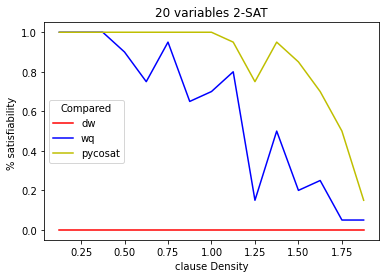

In [ ]:
data = np.genfromtxt('compare_2.csv', delimiter=',', 
                      names=['alpha', 'dw', 'wq', 'pycosat'])
fig = plt.figure()

ax1 = fig.add_subplot(111)

ax1.set_title("20 variables 2-SAT")
ax1.set_xlabel('clause Density')
ax1.set_ylabel('% satisfiability ')

ax1.plot(data['alpha'], data['dw'], color='r', label='dw')
ax1.plot(data['alpha'], data['wq'], color='b', label='wq')
ax1.plot(data['alpha'], data['pycosat'], color='y', label='pycosat')
plt.legend(title='Compared')
fig.show()

In [ ]:
!git clone https://817f39297e940726a8648b171b073bc8bd73f2f0@github.com/marcin119a/sat-experiments.git
%cd sat-experiments

Cloning into 'sat-experiments'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 81 (delta 29), reused 36 (delta 6), pack-reused 0
Unpacking objects: 100% (81/81), done.
/content/neuralheuristicsforsat/sat-experiments


In [ ]:
!git clone https://github.com/satproject/neuralheuristicsforsat.git
%cd neuralheuristicsforsat

Cloning into 'neuralheuristicsforsat'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 73 (delta 21), reused 6 (delta 1), pack-reused 25
Unpacking objects: 100% (73/73), done.
/content/neuralheuristicsforsat/sat-experiments/neuralheuristicsforsat


In [ ]:
!pip install -r requirements.in 
%tensorflow_version 1.12

In [ ]:
!pip install -r requirements.txt

  Cloning https://github.com/satproject/neuralheuristicsforsat to /tmp/pip-req-build-jx81kefg
  Running command git clone -q https://github.com/satproject/neuralheuristicsforsat /tmp/pip-req-build-jx81kefg
  Using cached https://files.pythonhosted.org/packages/22/cc/ca70b78087015d21c5f3f93694107f34ebccb3be9624385a911d4b52ecef/tensorflow-1.12.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/53/8d32ce9471c18f8d99028b7cef2e5b39ea8765bd7ef250ca05b490880971/tensorboard-1.12.2-py3-none-any.whl
  Created wheel for projekt-sat: filename=projekt_sat-1.0.0-cp36-none-any.whl size=1185 sha256=1f43153ad32eafafea95ddfb8a60b43ff632aaa73822f01ae32779a256df5b3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ofeitdsc/wheels/be/7f/db/6e8ebfa23a7134a0bf146cb48f6f2b433bf73645f9de997403
Successfully built projekt-sat
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found e

In [ ]:
import numpy as np
import random
from tqdm import trange
import pycosat


def generate_pycosat(n_variables, n_clauses, k_var):
    """
       Generates k_var-SAT problem in cnf-format
    """
    a = list(range(-n_variables, 0)) + list(range(1, n_variables + 1))
    b = [0 for _ in range(n_clauses)]
    current_clause_num = 0
    while current_clause_num < n_clauses:
        clause = []
        while True:
            var = random.choice(a)
            if var not in clause and -var not in clause:
                clause.append(var)
            if len(clause) == k_var:
                break
        if clause not in b:
            b[current_clause_num] = clause
            current_clause_num += 1
    return b


def data_to_matrix(m, n, data):
    matrix = np.zeros((m, n), dtype=np.int32)
    for j in range(m):
        var1, var2 = data[j][0], data[j][1]
        matrix[j][abs(var1) - 1] = var1 // abs(var1)
        matrix[j][abs(var2) - 1] = var2 // abs(var2)
    return matrix


def ising_params(m, n, matrix):
    """ Encoding SAT matrix to Ising 2-body Hamiltonian folowing
        S.Santra et al. Max 2-SAT with up to 108 qubits (2014)."""

    v = matrix

    # constructing Ising matrix and biases
    J = np.zeros((n, n), dtype=np.float32)
    h = np.zeros(n, dtype=np.float32)
    # the local fields

    for j in range(m):
        index1 = -1
        index2 = 0
        for i in range(n):
            if v[j, i] != 0 and index1 == -1:
                index1 = i + 1
                continue
            if v[j, i] != 0 and index1 != 0:
                index2 = i + 1
                break
        J[index1 - 1, index2 - 1] += v[j, index1 - 1] * v[j, index2 - 1]
        h[index1 - 1] += -v[j, index1 - 1]
        h[index2 - 1] += -v[j, index2 - 1]
    return J, h

n = 10 
m = 10
k = 2
sat_instance = generate_pycosat(n, m , k)





In [ ]:
import itertools
import os
import tensorflow as tf
from neuralheuristicsforsat.helpers import chunkIt, save_to_csv
import time


def predict():
    complexity = 50
    tfrecord_location = '/content/neuralheuristicsforsat/sat-experiments/sr_50/train_1000_sr_50.tfrecord'
    #filename = os.path.join(tfrecord_location, name)

    record_iterator = tf.python_io.tf_record_iterator(path=tfrecord_location)
    preds = []
    #targes = []
    batch_size = 100
    n = 50

    train_set = {'cnf': list(), 'sat': list()}
    sim_results = list()
    w = 0

    for string_record in itertools.islice(record_iterator, batch_size):
        example = tf.train.Example()
        example.ParseFromString(string_record)
        

        m = len(example.features.feature["inputs"].float_list.value) // 2
        
        inputs = chunkIt(example.features.feature["inputs"].float_list.value, m) #split examp: [0,1,2,3,4,5] into [0,1], [2,3], [4,5]
        print(inputs)


        train_set['cnf'].append(inputs)
        targ = int(example.features.feature["sat"].float_list.value[0])
        train_set['sat'].append(targ)

        start = time.time()

        qubo, const = formulate(inputs, complexity)
        
        # WQ
        bin_vector_wildqat = wq_solve(inputs, qubo) 
        sim_result = (np.dot(bin_vector_wildqat, np.dot(qubo, bin_vector_wildqat)) + const == 0)
        #pycosat
        pycosat_res = pycosat.solve(inputs) != 'UNSAT'
        # dwave
        print(m)
        bin_vector_dw = dw_solve(inputs, qubo, n, m)
        dw_result = np.dot(bin_vector_dw, np.dot(qubo, bin_vector_dw)) + const == 0
        #if np.dot(bin_vector_wildqat, np.dot(qubo, bin_vector_wildqat)) + const == 0:
        #    w = w + 1

        end = time.time()
        
        
        save_to_csv(file_name='logs_', data=[[m, m/n, bin_vector_wildqat, sim_result, dw_result, targ, end - start]], n=n)

        sim_results.append(sim_result)
        

    return (sim_results, train_set)

predict()

[[49, -26], [-5, -11], [9, 43], [-24, -13], [-15, 12], [-44, -10], [-46, 45], [-2, 46], [35, 45], [17, 19], [-1, -2], [19, -13], [-25, 43], [-15, -40], [-8, -25], [-24, -39], [-31, 1], [-10, 42], [-15, -2], [9, -9], [-23, -19], [44, 26], [15, -20], [-50, 21], [36, -7], [-27, -25], [34, 20], [3, 13], [22, 10], [5, -36], [-14, 7], [41, 11], [-50, 38], [-6, 18], [-14, 40], [40, 16], [-49, -15], [-11, -34], [46, 42], [30, -44], [-5, 18], [-2, -7], [-14, -15], [15, 15], [-3, 31], [42, -47], [-49, 13], [22, -17], [-26, -50], [28, 12], [-19, 19], [-49, -9], [-41, -11], [-15, 17], [23, 49], [-10, 29], [46, -9], [28, 20], [-6, 43], [-30, -25], [30, -48], [-19, 19], [16, 46], [-4, 49], [2, 49], [30, -32], [-46, 16], [-41, -41], [-41, 16], [41, 14], [-28, 27], [-21, 15], [23, 35], [28, 32], [24, -26], [13, -44], [6, -29], [32, -23], [4, -43], [27, 12], [-8, 24], [-37, 22], [-3, -36], [-30, 37], [25, 4], [21, -3], [-25, 14]]
87


NameError: ignored

In [ ]:
import wildqat as wq
import pycosat
from dwave.system.samplers import DWaveSample
from dwave.system.composites import EmbeddingComposite

def dw_solve(formulas, qubo, N, alpha):
    matrix = data_to_matrix(alpha, N, formulas)
    J, h = ising_params(alpha, N, matrix)
    token = "DEV-8bd0e05a8d9f1047675ff5d747d12bcc3c6ea3c2"

    h2  = { i: k for i, k in enumerate(h) }

    J2 = {}
    for i, x in enumerate(J):
        for j,m in enumerate(x):
            if m !=0:
                J2[(i,j)] = m


    sampler = EmbeddingComposite(DWaveSampler(token=token))
    #h = {'a': -1., 'b': 2} # przykladowe dane
    #J = {('a', 'b'): 1.5} # przykładowe dane
    sampleset = sampler.sample_ising(h2, J2)
    

    for sample in sampleset.samples():
        result = (sample)
    x = [1 if spin == 1 else 0 for key, spin in result.items()]

    return x

def wq_solve(formulas, qubo):
    wildqat_instance = wq.opt()
    wildqat_instance.qubo = qubo

    bin_vector_wildqat = wildqat_instance.sa()

    return bin_vector_wildqat

AttributeError: ignored

In [ ]:
!pip upgrade 

'1.18.3'